Pattern Recognition Project </br>
Project Name: Writer Independent Signature Verification (WISV) system</br>
Team members: Amirmohmmad taghizadehgan, Amirreza Radmanesh </br>
Student numbers: 40104244, 40106774

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil
import os

In [8]:
shutil.copy('/content/drive/My Drive/UTSig (pattern project).rar', '/content/UTSig (pattern project).rar')

'/content/UTSig (pattern project).rar'

In [9]:
!pip install unrar

In [10]:
!unrar x "/content/UTSig (pattern project).rar" > /dev/null

In [11]:
if os.path.exists('/content/Edited'):
  shutil.rmtree('/content/Edited')
for main in ['Train', 'Test']:
  shutil.copytree(f'/content/UTSig (pattern project)/Genuine/{main}', f'/content/Edited/{main}')
  for folder in os.listdir(f'/content/Edited/{main}/'):
    temp = f'/content/Edited/{main}/{folder}'
    shutil.copytree(temp, f'{temp}/Genuine')
    for file in os.listdir(temp):
      if os.path.isfile(f'{temp}/{file}'):
        os.remove(f'{temp}/{file}')

forgery_folder = '/content/UTSig (pattern project)/Forgery'
temp = os.listdir('/content/UTSig (pattern project)/Forgery/')
Test = os.listdir('/content/Edited/Test')
for style in temp:
  for folder in os.listdir(f'{forgery_folder}/{style}'):
    if folder in Test:
      for file in os.listdir(f'{forgery_folder}/{style}/{folder}'):
        if not os.path.exists(f'/content/Edited/Test/{folder}/Forgery/'):
          os.mkdir(f'/content/Edited/Test/{folder}/Forgery/')
        shutil.copy(f'{forgery_folder}/{style}/{folder}/{file}', f'/content/Edited/Test/{folder}/Forgery/{file}')
        shutil.move(f'/content/Edited/Test/{folder}/Forgery/{file}', f'/content/Edited/Test/{folder}/Forgery/{style}_{file}')
    else:
      if not os.path.exists(f'/content/Edited/Train/{folder}/Forgery/'):
          os.mkdir(f'/content/Edited/Train/{folder}/Forgery/')
      for file in os.listdir(f'{forgery_folder}/{style}/{folder}'):
        shutil.copy(f'{forgery_folder}/{style}/{folder}/{file}', f'/content/Edited/Train/{folder}/Forgery/{file}')
        shutil.move(f'/content/Edited/Train/{folder}/Forgery/{file}', f'/content/Edited/Train/{folder}/Forgery/{style}_{file}')


In [12]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_data(dataset_path):
    images = []
    labels = []

    for person_dir in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person_dir)

        genuine_path = os.path.join(person_path, "Genuine")
        forgery_path = os.path.join(person_path, "Forgery")

        for image_name in os.listdir(genuine_path):
            image_path = os.path.join(genuine_path, image_name)
            image = load_image(image_path)
            images.append(image)
            labels.append(int(person_dir))

        for image_name in os.listdir(forgery_path):
            image_path = os.path.join(forgery_path, image_name)
            image = load_image(image_path)
            images.append(image)
            labels.append(-int(person_dir))
    id = np.random.choice(len(images), len(images))
    return np.array(images)[id], np.array(labels)[id]

def load_image(image_path):
    image = load_img(image_path, target_size=(64, 64), color_mode="grayscale")
    image = img_to_array(image)
    image /= 255.0
    return image


images_te, labels_te = load_data(dataset_path = "/content/Edited/Test")
images_tr, labels_tr = load_data(dataset_path = "/content/Edited/Train")


In [13]:
def create_pair(images, labels):
  label = []
  pairs = []
  for id in np.arange(images.shape[0]):
    x1, y1 = images[id], labels[id]
    id2 = np.random.choice(len(images))
    x2, y2 = images[id2], labels[id2]
    pairs += [[x1, x2]]
    label += [y1 == y2]
  return np.array(pairs), np.array(label)

pairs_tr, pair_labels_tr = create_pair(images_tr, labels_tr)
pairs_te, pair_labels_te = create_pair(images_te, labels_te)


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

def build_base_network(input_shape):
    input = Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    return Model(input, x)

input_shape = (64, 64, 1)
base_network = build_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([processed_a, processed_b])
outputs = layers.Dense(1, activation='sigmoid')(distance)

model = Model([input_a, input_b], outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
history = model.fit(
    [pairs_tr[:int(pairs_tr.shape[0] * .7), 0], pairs_tr[:int(pairs_tr.shape[0] * .7), 1]], pair_labels_tr[:int(pairs_tr.shape[0] * .7)],
    validation_data=([pairs_tr[int(pairs_tr.shape[0] * .7):, 0], pairs_tr[int(pairs_tr.shape[0] * .7):, 1]], pair_labels_tr[int(pairs_tr.shape[0] * .7):]),
    batch_size=32,
    epochs=20
)


Epoch 1/20
145/145 [==============================] - 8s 22ms/step - loss: 0.0765 - accuracy: 0.9944 - val_loss: 0.0232 - val_accuracy: 0.9950
Epoch 2/20
145/145 [==============================] - 3s 20ms/step - loss: 0.0260 - accuracy: 0.9946 - val_loss: 0.0221 - val_accuracy: 0.9950
Epoch 3/20
145/145 [==============================] - 2s 16ms/step - loss: 0.0210 - accuracy: 0.9946 - val_loss: 0.0220 - val_accuracy: 0.9950
Epoch 4/20
145/145 [==============================] - 2s 15ms/step - loss: 0.0215 - accuracy: 0.9946 - val_loss: 0.0266 - val_accuracy: 0.9950
Epoch 5/20
145/145 [==============================] - 2s 16ms/step - loss: 0.0155 - accuracy: 0.9948 - val_loss: 0.0255 - val_accuracy: 0.9940
Epoch 6/20
145/145 [==============================] - 2s 16ms/step - loss: 0.0104 - accuracy: 0.9965 - val_loss: 0.0294 - val_accuracy: 0.9955
Epoch 7/20
145/145 [==============================] - 2s 17ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.0343 - val_accuracy: 0.9950

In [16]:
model.evaluate([pairs_te[:, 0], pairs_te[:, 1]], pair_labels_te)

52/52 [==============================] - 1s 10ms/step - loss: 0.3078 - accuracy: 0.9777


[0.30776816606521606, 0.9776570200920105]

52/52 [==============================] - 0s 5ms/step


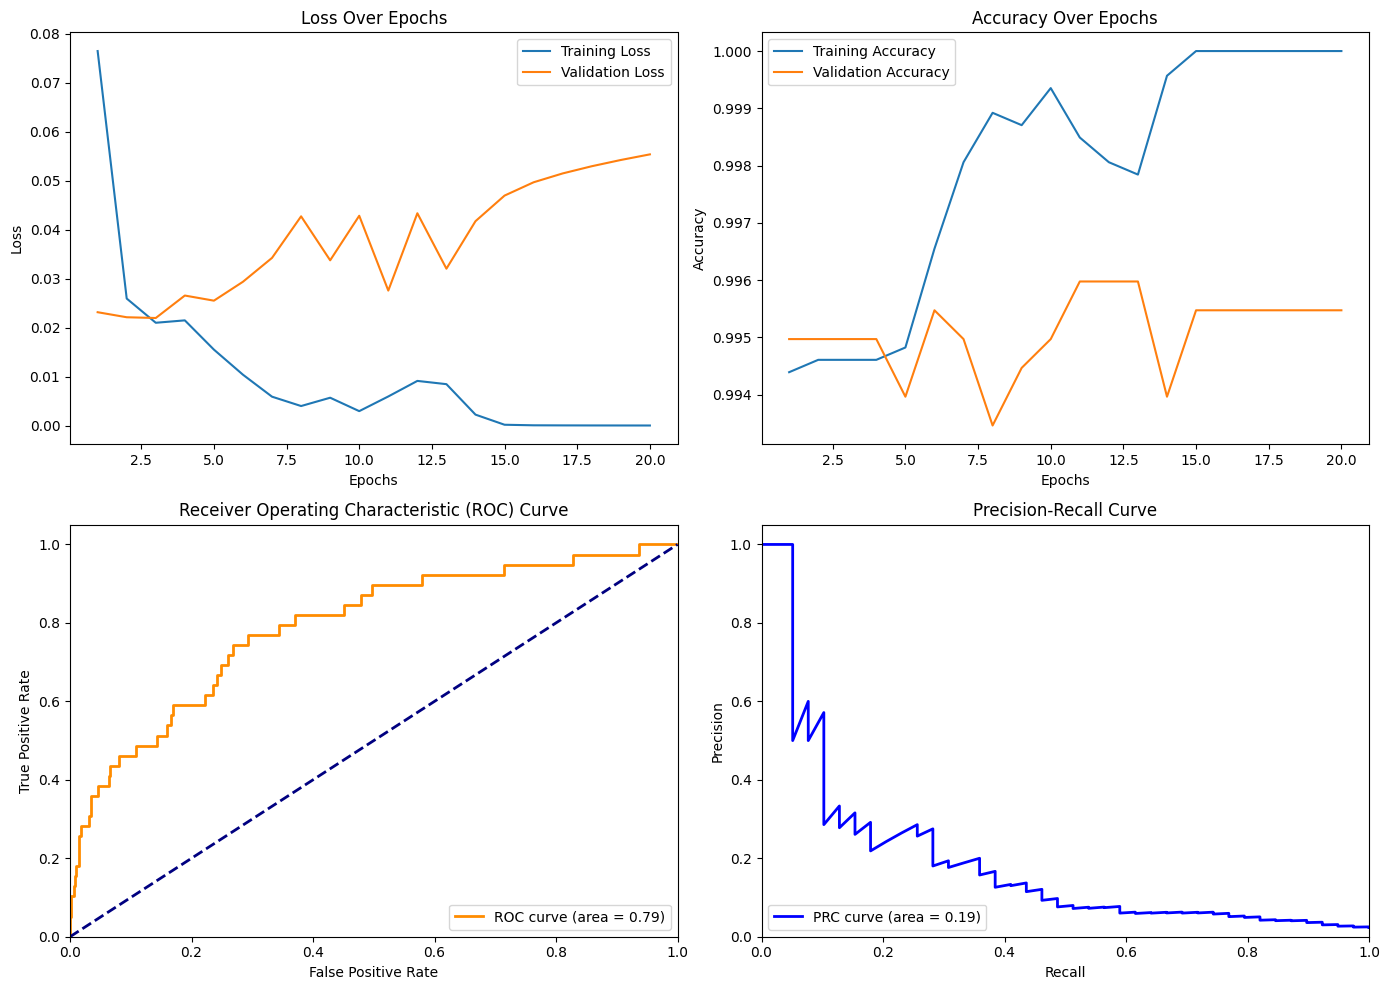

Optimal threshold: 4.299651e-08
Equal Error Rate (EER): 0.2683982683982684
False Acceptance Rate (FAR): 0.2925170068027211
False Rejection Rate (FRR): 0.23076923076923073
Accuracy at optimal threshold: 0.6870120947980116
Confusion Matrix:
 [[1144  473]
 [   9   30]]

Insights:
1. The optimal threshold is determined by maximizing the difference between the True Positive Rate (TPR) and False Positive Rate (FPR).
2. The EER is the point where the False Acceptance Rate (FAR) equals the False Rejection Rate (FRR).
3. The confusion matrix provides a detailed breakdown of the model's performance at the chosen threshold.
4. Choosing the optimal threshold balances the trade-off between FAR and FRR, impacting the system's performance.



In [26]:
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

y_true = pair_labels_te
y_pred_prob = model.predict([pairs_te[:, 0], pairs_te[:, 1]])

# Compute ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_prob)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Plot ROC Curve
plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Compute Precision-Recall curve and AUC
precision, recall, thresholds_prc = precision_recall_curve(y_true, y_pred_prob)
prc_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.subplot(2, 2, 4)
plt.plot(recall, precision, color='blue', lw=2, label='PRC curve (area = %0.2f)' % prc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Determine the optimal threshold (example using ROC curve)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
print('Optimal threshold:', optimal_threshold)

# Calculate EER
eer_threshold = thresholds_roc[np.nanargmin(np.absolute((1 - tpr) - fpr))]
eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]
print('Equal Error Rate (EER):', eer)

# Calculate FAR and FRR
far = fpr[optimal_idx]
frr = 1 - tpr[optimal_idx]
print('False Acceptance Rate (FAR):', far)
print('False Rejection Rate (FRR):', frr)

# Calculate accuracy at the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
accuracy_optimal = np.mean(y_pred_optimal == y_true)
print('Accuracy at optimal threshold:', accuracy_optimal)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_optimal)
print('Confusion Matrix:\n', conf_matrix)

print("""
Insights:
1. The optimal threshold is determined by maximizing the difference between the True Positive Rate (TPR) and False Positive Rate (FPR).
2. The EER is the point where the False Acceptance Rate (FAR) equals the False Rejection Rate (FRR).
3. The confusion matrix provides a detailed breakdown of the model's performance at the chosen threshold.
4. Choosing the optimal threshold balances the trade-off between FAR and FRR, impacting the system's performance.
""")
